To use this Notebook:
  - import the StaffPlanning example (New Decision Optimization Model/From File)
  - generate the project token code (From the notebook menu, do "Insert project token")



In [ ]:
!pip install --user decision_optimization_client


### Client

Create a DODS client to connect to initial scenario.

In [ ]:
from decision_optimization_client import *

# In order to use the solve() function, you must provide an API key when creating the client
client = Client(pc=pc, apikey='IAM_APIKEY')
decision = client.get_experiment(name="StaffPlanning")
scenario = decision.get_scenario(name="Scenario 1")


### Global parameters

The number of days and number of periods per day:

In [ ]:
N_DAYS = 2
N_PERIODS_PER_DAY = 24*4
N_PERIODS = N_DAYS * N_PERIODS_PER_DAY

### Random generator

A method to generate the random demand for the given number of days and periods. 

In [ ]:
import random
import numpy as np
import pandas as pd

def random_demand( b_size ):
    rs = []
    for d in range(N_DAYS):
        # Morning
        p1 = random.uniform(0.2, 0.4)
        s1 = int(random.uniform(b_size*0.5, b_size*1.5))
        rs.append(np.random.binomial(n=N_PERIODS_PER_DAY, p=p1, size=s1) + d*N_PERIODS_PER_DAY)
        # Afternoon
        p2 = random.uniform(0.6, 0.8)
        s2 = int(random.uniform(b_size*0.5, b_size*1.5))
        rs.append(np.random.binomial(n=N_PERIODS_PER_DAY, p=p2, size=s2) + d*N_PERIODS_PER_DAY)
        # Rest of day
        s3 = int(random.uniform(b_size*0.4, b_size*0.7))
        e = np.array([ random.randint(int(d*N_PERIODS_PER_DAY + 0.2*N_PERIODS_PER_DAY), int(d*N_PERIODS_PER_DAY + 0.8*N_PERIODS_PER_DAY)) for i in range(s3) ])
        #print(e)
        rs.append(e)
    #print(rs)
    s = np.concatenate(rs)
    #print(s)
    g_arrivals = pd.DataFrame(data=s, columns=['value'])
    _demands = [0 for i in range(0, N_PERIODS+1)]
    for t in s:
        _demands[t] = _demands[t] +1
    demands = pd.DataFrame(data= [(t, _demands[t]) for t in range(N_PERIODS)], columns = ['period', 'demand'])
    return demands


The number of scenarios you want to generate and solve:

In [ ]:
N_SCENARIOS = 5


When copying the scenario, copy the input data, the model and the solution if any.

Then attach new randomly generated data and solve.

Grab the solution to perform some multi scenario reporting in this notebook.

In [ ]:
all_kpis = pd.DataFrame()

for i in range(1, N_SCENARIOS+1):
    sc_name = "Copy %02d" % (i)
    print(sc_name)
    copy = decision.get_scenario(name=sc_name)
    if (copy != None):
        print(" Deleting old...")
        decision.delete_container(copy)
    print(" Copying from original scenario...")    
    copy = scenario.copy(sc_name)
    print(" Generating new demand...")
    df_demands = random_demand(200)
    copy.add_table_data("demands", df_demands, category='input')
    print(" Solving...")
    copy.solve()
    print(" Grabbing solution kpis...")
    kpis = copy.get_table_data('kpis')
    kpis['scenario'] = sc_name
    mk = [[ kpis.iloc[0]['Value'],  "%02d" % (kpis.iloc[1]['Value']), sc_name, "%02d" % (kpis.iloc[2]['Value'])]]
    my_kpis = pd.DataFrame(data=mk, columns=['cost','fix','scenario','temp'])
    copy.add_table_data('my_kpis', data=my_kpis, category='output')
    all_kpis = all_kpis.append(kpis)
    
print("Done!")

Copy 01
 Deleting old...
 Copying from original scenario...
 Generating new demand...
 Solving...
 Grabbing solution kpis...
Copy 02
 Deleting old...
 Copying from original scenario...
 Generating new demand...
 Solving...
 Grabbing solution kpis...
Copy 03
 Deleting old...
 Copying from original scenario...
 Generating new demand...
 Solving...
 Grabbing solution kpis...
Copy 04
 Deleting old...
 Copying from original scenario...
 Generating new demand...
 Solving...
 Grabbing solution kpis...
Copy 05
 Deleting old...
 Copying from original scenario...
 Generating new demand...
 Solving...
 Grabbing solution kpis...
Done!


### Reporting

Display multi scenario comparison report.

In [ ]:
total_cost = all_kpis[all_kpis.Name=='Total Cost']

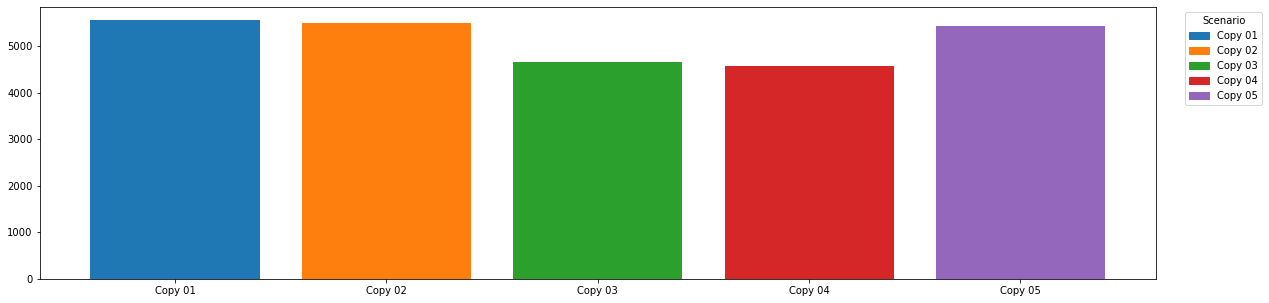

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

my_colors = mcolors.TABLEAU_COLORS

plot = plt.figure(figsize=(20,5))

plot = plt.bar(range(N_SCENARIOS),[total_cost.iloc[i]['Value'] for i in range(N_SCENARIOS)], width = 0.8, color = my_colors)
plot = plt.xticks(range(N_SCENARIOS),[total_cost.iloc[i]['scenario'] for i in range(N_SCENARIOS)])

labels = list(total_cost.iloc[i]['scenario'] for i in range(N_SCENARIOS))
handles = [plt.Rectangle((0,0),1,1, color = my_colors[v_color]) for v_color in my_colors]
plot = plt.legend(handles, labels, title = 'Scenario', loc = 'upper right', bbox_to_anchor=(1.1, 1))

Copyright &copy; 2017-2022 IBM. This notebook and its source code are released under the terms of the MIT License.